In [1]:
import nest_asyncio
import sys
from green_mood_tracker.twint_class import TWINT
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download
from green_mood_tracker.training_data import get_raw_data_notebook

In [2]:
raw_data = get_raw_data_notebook()

/Users/henryhall/.pyenv/versions/3.7.7/envs/lewagon-3.7/lib/python3.7/site-packages/green_mood_tracker/training_data.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sentiment140_final['polarity'] = sentiment140_final.polarity.map({4:2,0:0})
/Users/henryhall/.pyenv/versions/3.7.7/envs/lewagon-3.7/lib/python3.7/site-packages/green_mood_tracker/training_data.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sentiment140_final['source'] = 'sentiment140'


In [3]:
from green_mood_tracker.data_cleaning import clean
raw_data = get_raw_data_notebook()
raw_data_clean = clean(raw_data,'text')
raw_data_clean.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/henryhall/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,text,polarity,source
0,1467933112,angel going miss athlete weekend,0,sts_gold
1,2323395086,look though shaq getting traded cleveland play...,0,sts_gold
2,1467968979,april th isnt coming soon enough,0,sts_gold
3,1990283756,drinking mcdonalds coffee understanding someon...,0,sts_gold
4,1988884918,dissapointed taylor swift doesnt twitter,0,sts_gold


In [4]:
raw_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1633048 entries, 0 to 1599999
Data columns (total 4 columns):
id          1633048 non-null object
text        1633048 non-null object
polarity    1633048 non-null int64
source      1633048 non-null object
dtypes: int64(1), object(3)
memory usage: 62.3+ MB


In [5]:
raw_data_clean = raw_data_clean[raw_data_clean['polarity']!=1]

In [37]:
data_sample = raw_data_clean.sample(n=30_000,random_state=0).reset_index()
data_sample.head()

,index,id,text,polarity,source
0,336834,2014083611,pinch even fought amma hate new goatee sd look...,0,sentiment140
1,622734,2229303528,didnt even get try week,0,sentiment140
2,1016867,1881768019,giving jack quick hair cut,2,sentiment140
3,1090541,1969804803,pirate game sat sun work monday tuesthur work ...,2,sentiment140
4,947493,1823084268,fun night,2,sentiment140


In [38]:
data_sample['polarity'] = data_sample.polarity.map({2:1,0:0})
data_sample.head()

,index,id,text,polarity,source
0,336834,2014083611,pinch even fought amma hate new goatee sd look...,0,sentiment140
1,622734,2229303528,didnt even get try week,0,sentiment140
2,1016867,1881768019,giving jack quick hair cut,1,sentiment140
3,1090541,1969804803,pirate game sat sun work monday tuesthur work ...,1,sentiment140
4,947493,1823084268,fun night,1,sentiment140


In [7]:
# data_sample['text'] = data_sample.text.apply((lambda x: x.split()))

In [39]:
from sklearn.model_selection import train_test_split

X = data_sample.text
y = data_sample.polarity

sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [ ]:
!pip install absl-py --quiet

In [13]:
!pip install tensorflow-datasets --quiet

You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
!pip install transformers --quiet

You should consider upgrading via the 'pip install --upgrade pip' command.


In [40]:
import pandas as pd
# Recommended tensorflow version is <= 2.1.0, otherwise F1 score function breaks
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
from transformers import TFRobertaForSequenceClassification
from transformers import RobertaTokenizer
import os

In [41]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [18]:
max_length = 100

# the recommended batches size for BERT are 32,64 ... however on this dataset we are overfitting quite fast
# and smaller batches work like a regularization.
# You might play with adding another dropout layer instead.

batch_size = 64

In [19]:
def convert_example_to_feature(review):
    # combine step for tokenization, WordPiece vector mapping and will
    # add also special tokens and truncate reviews longer than our max length
    return roberta_tokenizer.encode_plus(review,
                                 add_special_tokens=True,  # add [CLS], [SEP]
                                 max_length=max_length,  # max length of the text that can go to RoBERTa
                                 pad_to_max_length=True,  # add [PAD] tokens at the end of sentence
                                 return_attention_mask=True,  # add attention mask to not focus on pad tokens
                                 )

In [20]:
# map to the expected input to TFRobertaForSequenceClassification, see here
def map_example_to_dict(input_ids, attention_masks, label):
    return {
      "input_ids": input_ids,
      "attention_mask": attention_masks,
           }, label

In [21]:
def encode_examples(ds, limit=-1):
    # Prepare Input list
    input_ids_list = []
    attention_mask_list = []
    label_list = []

    if (limit > 0):
        ds = ds.take(limit)

    for review, label in tfds.as_numpy(ds):
        bert_input = convert_example_to_feature(review.decode())
        input_ids_list.append(bert_input['input_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices((input_ids_list,
                                               attention_mask_list,
                                               label_list)).map(map_example_to_dict)

In [42]:
training_sentences_modified = tf.data.Dataset.from_tensor_slices((sentence_train,
                                                                  y_train))

testing_sentences_modified = tf.data.Dataset.from_tensor_slices((sentence_test,
                                                                 y_test))

ds_train_encoded = encode_examples(training_sentences_modified).shuffle(10000).batch(batch_size)
ds_test_encoded = encode_examples(testing_sentences_modified).batch(batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/henryhall/.pyenv/versions/3.7.7/envs/lewagon-3.7/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [29]:
learning_rate = 7e-5
number_of_epochs = 8

In [ ]:
# class ModelMetrics(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.count_n = 1

#     def on_epoch_end(self, batch, logs={}):
        
#         os.mkdir('/create/directory/for/model/' + str(self.count_n))
#         self.model.save_pretrained('/save/trained/model/here/' + str(self.count_n)) # this folder address should match with folder we created above
        
#         y_val_pred = tf.nn.softmax(self.model.predict(ds_test_encoded))
#         y_pred_argmax = tf.math.argmax(y_val_pred, axis=1)
#         testing_copy = testing_sentences.copy()
#         testing_copy['predicted'] = y_pred_argmax
#         f1_s = f1_score(testing_sentences['label'], testing_copy['predicted'])
#         print('\n f1 score is :', f1_s)
#         self.count_n += 1

# metrics = ModelMetrics()

In [43]:
model = TFRobertaForSequenceClassification.from_pretrained("roberta-base")
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2,restore_best_weights=True,monitor='val_accuracy')
history = model.fit(ds_train_encoded, epochs=number_of_epochs,
          validation_data=ds_test_encoded, callbacks=[es])

Epoch 1/8
329/329 [==============================] - 8985s 27s/step - loss: 0.5589 - accuracy: 0.7152 - val_loss: 0.5177 - val_accuracy: 0.7627
Epoch 2/8
329/329 [==============================] - 7261s 22s/step - loss: 0.4618 - accuracy: 0.7859 - val_loss: 0.4766 - val_accuracy: 0.7741
Epoch 3/8
329/329 [==============================] - 7122s 22s/step - loss: 0.4019 - accuracy: 0.8241 - val_loss: 0.5345 - val_accuracy: 0.7770
Epoch 4/8
329/329 [==============================] - 7007s 21s/step - loss: 0.3384 - accuracy: 0.8598 - val_loss: 0.4928 - val_accuracy: 0.7824
Epoch 5/8
329/329 [==============================] - 7006s 21s/step - loss: 0.2740 - accuracy: 0.8918 - val_loss: 0.5965 - val_accuracy: 0.7676
Epoch 6/8
329/329 [==============================] - 7104s 22s/step - loss: 0.2168 - accuracy: 0.9187 - val_loss: 0.6561 - val_accuracy: 0.7722


In [45]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

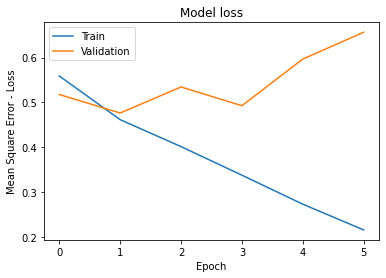

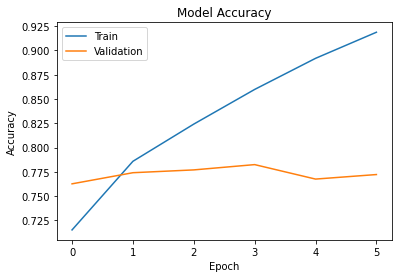

In [47]:
plot_loss(history)

In [48]:
model.evaluate(ds_test_encoded,y_test)

ValueError: `y` argument is not supported when using dataset as input.